In [2]:
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io

from scipy.linalg import solve_continuous_are

from ocslc.switched_linear_mpc import SwiLin
from optimizers.sgd import StochasticGradientDescent, RMSPropOptimizer, AdamOptimizer
from optimizers.sgd import sgd_optimize, rmsprop_optimize, adam_optimize

def switched_problem(n_phases=5):
    """
    Set up a switched linear problem and compute cost and gradient functions
    """
    model = {
        'A': [
            np.array([[-2.5, 0.5, 0.3], [0.4, -2.0, 0.6], [0.2, 0.3, -1.8]]),
            np.array([[-1.9, 3.2, 0.4], [0.3, -2.1, 0.5], [0, 0.6, -2.3]]),
            np.array([[-2.2, 0, 0.5],   [0.2, -1.7, 0.4], [0.3, 0.2, -2.0]]),
            np.array([[-1.8, 0.3, 0.2], [0.5, -2.4, 0],   [0.4, 0, -2.2]]),
            np.array([[-2.0, 0.4, 0],   [0.3, -2.2, 0.2], [0.5, 0.3, -1.9]]),
            np.array([[-2.3, 0.2, 0.3], [0, -2.0, 0.4],   [0.2, 0.5, -2.1]]),
            np.array([[-1.7, 0.5, 0.4], [0.2, -2.5, 0.3], [1.1, 0.2, -2.4]]),
            np.array([[-2.1, 0.3, 0.2], [0.4, -1.9, 0.5], [0.3, 0.1, -2.0]]),
            np.array([[-2.4, 0, 0.5],   [0.2, -2.3, 0.3], [0.4, 0.2, -1.8]]),
            np.array([[-1.8, 0.4, 0.3], [0.5, -2.1, 0.2], [0.2, 3.1, -2.2]]),
        ],
        'B': [
            np.array([[1.5, 0.3], [0.4, 1.2], [0.2, 0.8]]),
            np.array([[1.2, 0.5], [0.3, 0.9], [0.4, 1.1]]),
            np.array([[1.0, 0.4], [0.5, 1.3], [0.3, 0.7]]),
            np.array([[1.4, 0.2], [0.6, 1.0], [0.1, 0.9]]),
            np.array([[1.3, 0.1], [0.2, 1.4], [0.5, 0.6]]),
            np.array([[1.1, 0.3], [0.4, 1.5], [0.2, 0.8]]),
            np.array([[1.6, 0.2], [0.3, 1.1], [0.4, 0.7]]),
            np.array([[1.0, 0.4], [0.5, 1.2], [0.3, 0.9]]),
            np.array([[1.2, 0.5], [0.1, 1.3], [0.6, 0.8]]),
            np.array([[1.4, 0.3], [0.2, 1.0], [0.5, 0.7]]),
        ],
    }

    n_states = model['A'][0].shape[0]
    n_inputs = model['B'][0].shape[1]

    time_horizon = 10

    x0 = np.array([2, -1, 5])
    
    xr = np.array([1, -3])
    
    swi_lin = SwiLin(
        n_phases, 
        n_states,
        n_inputs,
        time_horizon, 
        auto=False, 
    )
    
    # Load model
    swi_lin.load_model(model)

    Q = 10. * np.eye(n_states)
    R = 10. * np.eye(n_inputs)
    E = 1. * np.eye(n_states)

    swi_lin.precompute_matrices(x0, Q, R, E)
    x0 = np.append(x0, 1)  # augment with 1 for affine term
    J_func = swi_lin.cost_function(R, x0)
        
    grad_J_u = []
    grad_J_delta = []

    for k in range(n_phases):
        # Compute gradient of the cost
        du, d_delta = swi_lin.grad_cost_function(k, R)
        # print(f"Length du: {len(du)}")

        grad_J_u += du
        grad_J_delta.append(d_delta)

    grad_J = ca.vertcat(*grad_J_delta, *grad_J_u)

    # keep the original stacked forms if needed
    grad_J_u = np.hstack(grad_J_u)
    grad_J_delta = np.hstack(grad_J_delta)
    
    # Create a CasADi function for the gradient
    grad_J_func = ca.Function('grad_J', [*swi_lin.u, *swi_lin.delta], [grad_J])
    
    # Create wrapper functions for the optimizer
    def cost_function(params, indices=None, data=None):
        """
        params: 1D array (n_params,) or 2D array (batch_size, n_params)
        indices: optional indices to select a minibatch from a 2D params array
        Returns the scalar loss (averaged over minibatch if batch provided).
        """
        params = np.asarray(params)
        # From a single flattened params vector, unpack into controls and durations
        u = params[:n_phases * n_inputs].reshape((n_phases, n_inputs)).tolist()
        phases_duration = params[n_phases * n_inputs:].reshape((n_phases,)).tolist()
        params_list = u + phases_duration
        # Compute the cost function for a single example (no batch)
        J = float(J_func(*params_list).full().item())
        J = 0
        
        if data is not None:
            u = data['controls'].ravel()
            phases_duration = data['phases_duration'].ravel()
            params_ref = np.concatenate([u, phases_duration])
            # print(f"Reference params: {params_ref}")
            
            # Compute the loss wrt reference params
            params_ref = np.asarray(params_ref)
            # add numpy sum of squared differences to scalar loss
            J += float(np.sum((params - params_ref) ** 2) / len(params_ref))

        return J

    def gradient_function(params, indices=None, data=None):
        """
        params: 1D array (n_params,) or 2D array (batch_size, n_params)
        indices: optional indices to select a minibatch from a 2D params array
        Returns gradient vector (n_params,) averaged over minibatch if batch provided.
        """
        params = np.asarray(params)
        # From a single flattened params vector, unpack into controls and durations
        u = params[:n_phases * n_inputs].reshape((n_phases, n_inputs)).tolist()
        phases_duration = params[n_phases * n_inputs:].reshape((n_phases,)).tolist()
        params_list = u + phases_duration
        # single example
        grad_J = np.asarray(grad_J_func(*params_list).full().ravel())
        grad_J = 0

        if data is not None:
            u = data['controls'].ravel()
            phases_duration = data['phases_duration'].ravel()
            params_ref = np.concatenate([u, phases_duration])
            params_ref = np.asarray(params_ref)
            # add gradient of the squared differences to grad_J
            grad_J = 2 * (params - params_ref) / len(params_ref)

        return grad_J


    return J_func, grad_J_func, cost_function, gradient_function

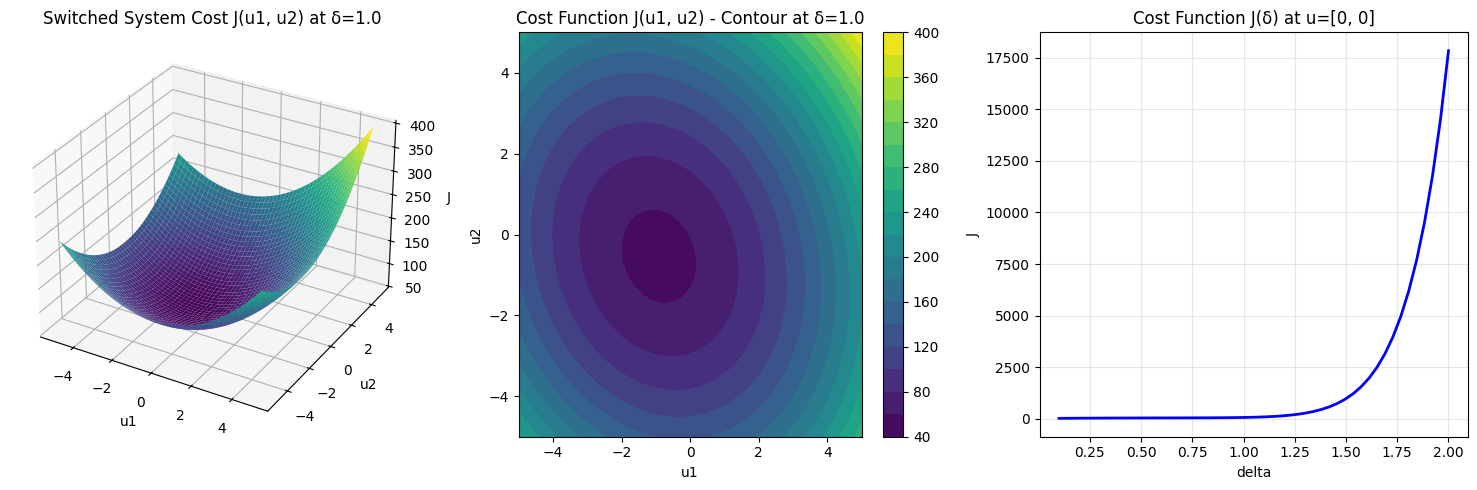

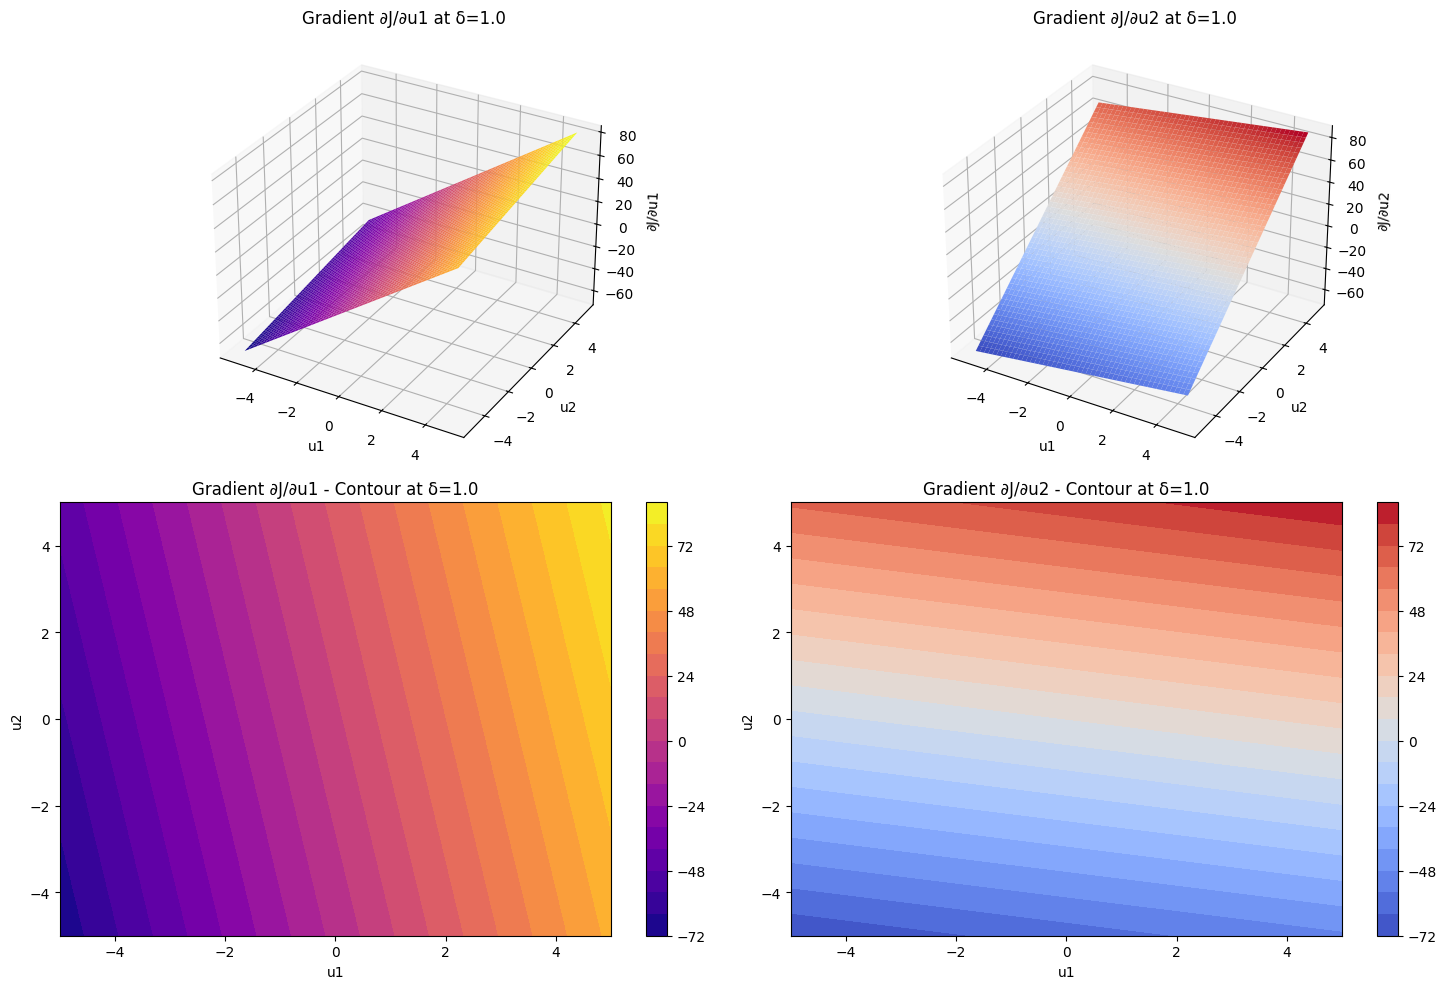

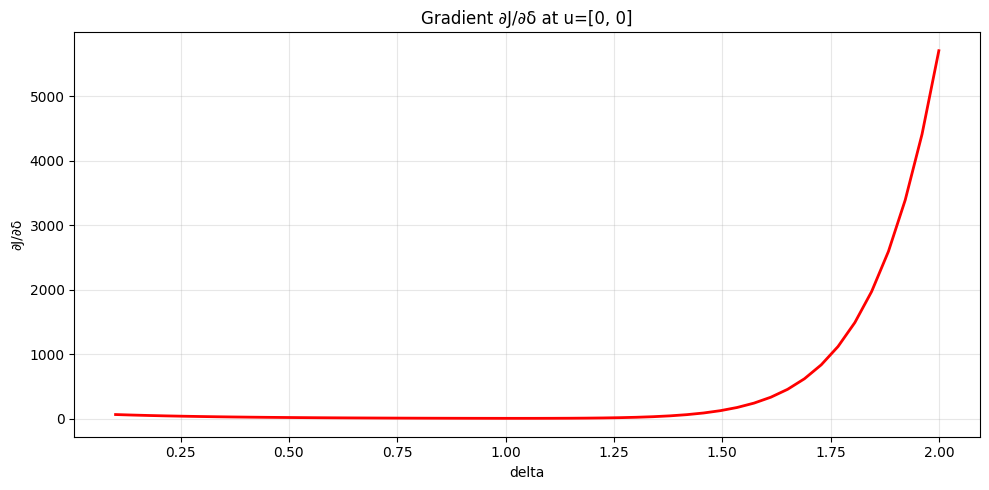

In [3]:
# Get the cost and gradient functions from the switched problem
J_func, grad_J_func, cost_function, gradient_function = switched_problem(n_phases=1)

# Define range for u and delta (for single phase problem)
n_phases = 1
n_inputs = 2
u1_values = np.linspace(-5, 5, 50)
u2_values = np.linspace(-5, 5, 50)
delta_values_switch = np.linspace(0.1, 2.0, 50)

# Create 2D plots for cost function with respect to (u1, u2) at fixed delta
U1, U2 = np.meshgrid(u1_values, u2_values)
J_switch = np.zeros_like(U1)
fixed_delta = 1.0

for i in range(len(u2_values)):
    for j in range(len(u1_values)):
        u = [[u1_values[j], u2_values[i]]]
        phases_duration = [fixed_delta]
        J_switch[i, j] = float(J_func(*u, *phases_duration).full().item())

# Create plots
fig = plt.figure(figsize=(15, 5))

# 3D surface plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(U1, U2, J_switch, cmap='viridis')
ax1.set_xlabel('u1')
ax1.set_ylabel('u2')
ax1.set_zlabel('J')
ax1.set_title(f'Switched System Cost J(u1, u2) at δ={fixed_delta}')

# Contour plot
ax2 = fig.add_subplot(132)
contour = ax2.contourf(U1, U2, J_switch, levels=20, cmap='viridis')
ax2.set_xlabel('u1')
ax2.set_ylabel('u2')
ax2.set_title(f'Cost Function J(u1, u2) - Contour at δ={fixed_delta}')
plt.colorbar(contour, ax=ax2)

# Plot cost vs delta at fixed u
ax3 = fig.add_subplot(133)
J_vs_delta = np.zeros(len(delta_values_switch))
fixed_u = [[0.0, 0.0]]
for i, delta in enumerate(delta_values_switch):
    J_vs_delta[i] = float(J_func(*fixed_u, delta).full().item())
ax3.plot(delta_values_switch, J_vs_delta, 'b-', linewidth=2)
ax3.set_xlabel('delta')
ax3.set_ylabel('J')
ax3.set_title('Cost Function J(δ) at u=[0, 0]')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot gradients
fig2 = plt.figure(figsize=(15, 10))

# Calculate gradients at fixed delta
grad_u1 = np.zeros_like(U1)
grad_u2 = np.zeros_like(U2)

for i in range(len(u2_values)):
    for j in range(len(u1_values)):
        u = [[u1_values[j], u2_values[i]]]
        phases_duration = [fixed_delta]
        grad = np.array(grad_J_func(*u, *phases_duration).full()).ravel()
        grad_u1[i, j] = grad[1]  # gradient wrt u1
        grad_u2[i, j] = grad[2]  # gradient wrt u2

# Plot gradient wrt u1
ax4 = fig2.add_subplot(221, projection='3d')
ax4.plot_surface(U1, U2, grad_u1, cmap='plasma')
ax4.set_xlabel('u1')
ax4.set_ylabel('u2')
ax4.set_zlabel('∂J/∂u1')
ax4.set_title(f'Gradient ∂J/∂u1 at δ={fixed_delta}')

# Plot gradient wrt u2
ax5 = fig2.add_subplot(222, projection='3d')
ax5.plot_surface(U1, U2, grad_u2, cmap='coolwarm')
ax5.set_xlabel('u1')
ax5.set_ylabel('u2')
ax5.set_zlabel('∂J/∂u2')
ax5.set_title(f'Gradient ∂J/∂u2 at δ={fixed_delta}')

# Contour plots
ax6 = fig2.add_subplot(223)
contour1 = ax6.contourf(U1, U2, grad_u1, levels=20, cmap='plasma')
ax6.set_xlabel('u1')
ax6.set_ylabel('u2')
ax6.set_title(f'Gradient ∂J/∂u1 - Contour at δ={fixed_delta}')
plt.colorbar(contour1, ax=ax6)

ax7 = fig2.add_subplot(224)
contour2 = ax7.contourf(U1, U2, grad_u2, levels=20, cmap='coolwarm')
ax7.set_xlabel('u1')
ax7.set_ylabel('u2')
ax7.set_title(f'Gradient ∂J/∂u2 - Contour at δ={fixed_delta}')
plt.colorbar(contour2, ax=ax7)

plt.tight_layout()
plt.show()

# Plot gradient wrt delta
grad_delta_vs_delta = np.zeros(len(delta_values_switch))
for i, delta in enumerate(delta_values_switch):
    grad = np.array(grad_J_func(*fixed_u, delta).full()).ravel()
    grad_delta_vs_delta[i] = grad[0]  # gradient wrt delta

fig3 = plt.figure(figsize=(10, 5))
ax8 = fig3.add_subplot(111)
ax8.plot(delta_values_switch, grad_delta_vs_delta, 'r-', linewidth=2)
ax8.set_xlabel('delta')
ax8.set_ylabel('∂J/∂δ')
ax8.set_title('Gradient ∂J/∂δ at u=[0, 0]')
ax8.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

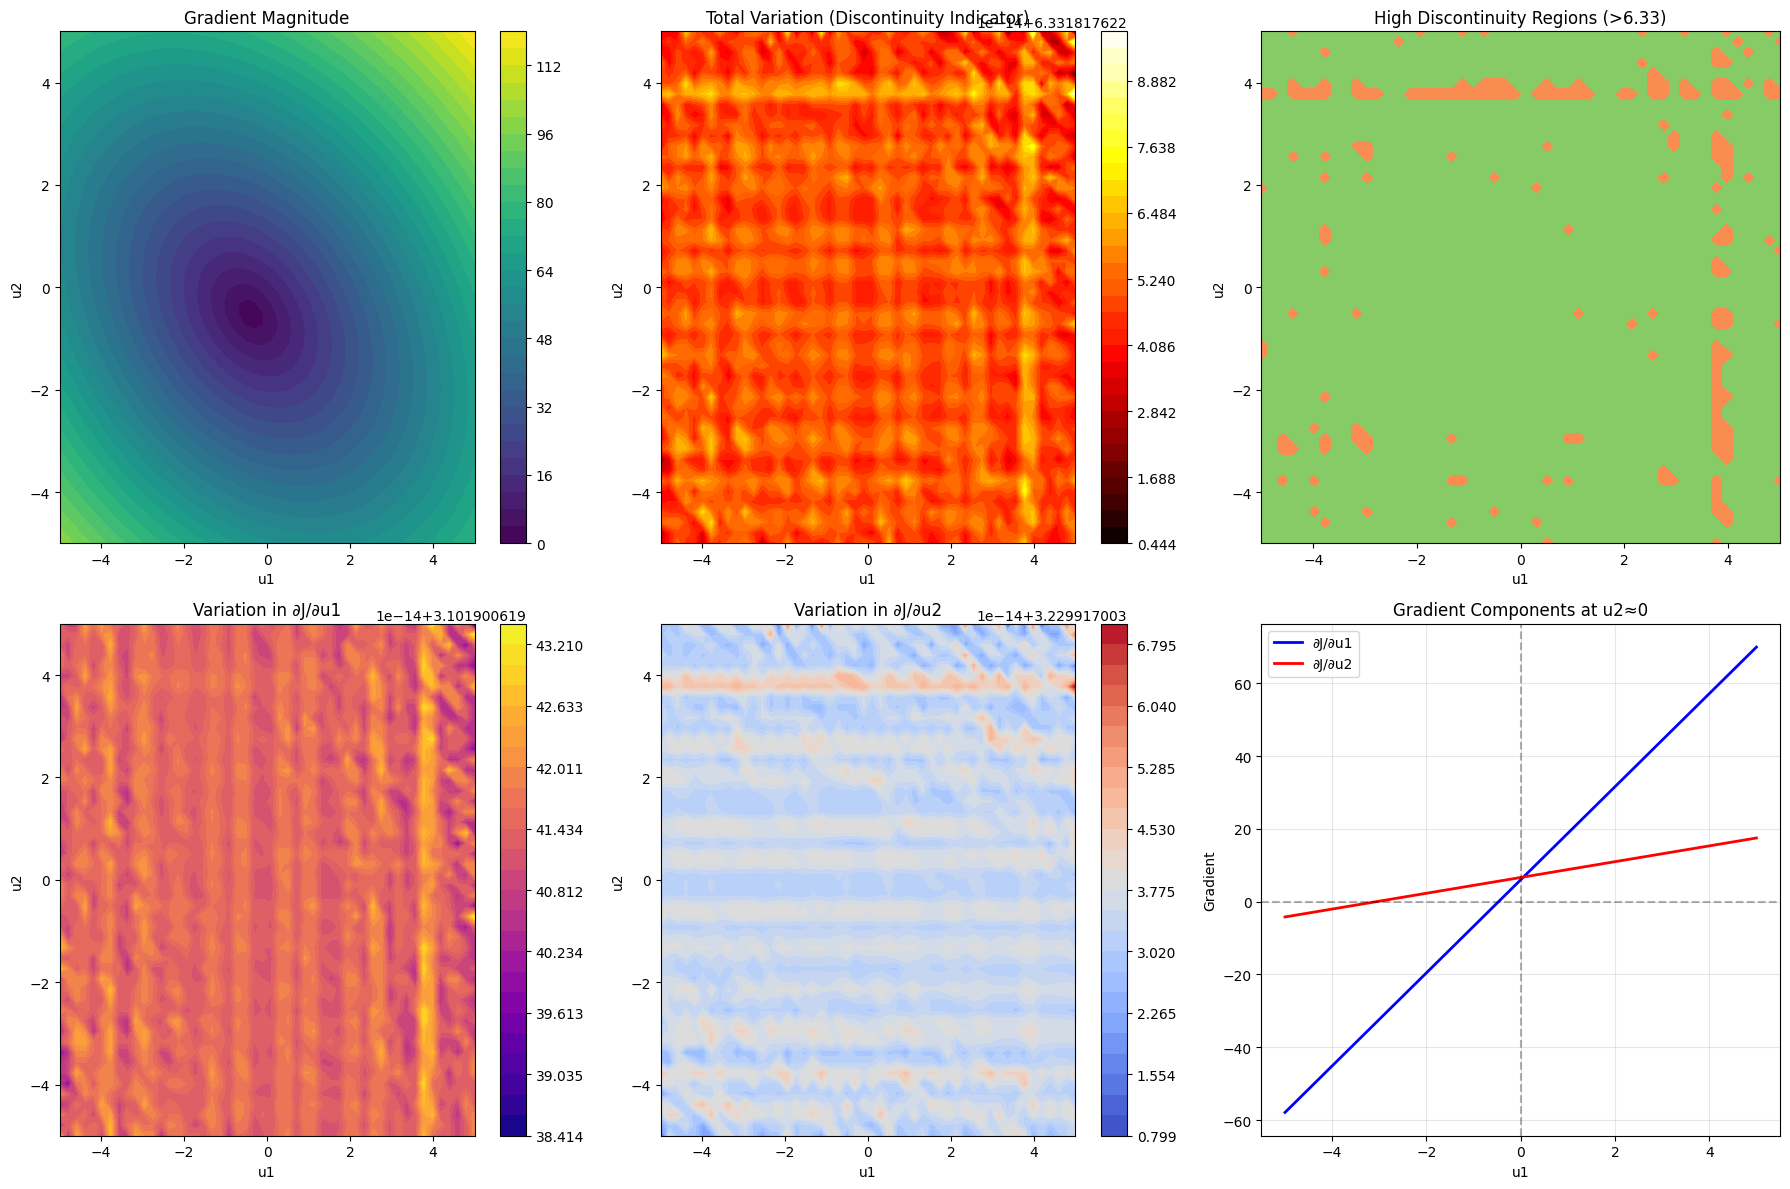

Discontinuity Analysis:
Total variation range: [6.3318, 6.3318]
Mean total variation: 6.3318
90th percentile threshold: 6.3318

Percentage of points with high variation: 7.12%

Maximum discontinuity at:
  u1 = 5.0000
  u2 = 3.7755
  Total variation = 6.3318


In [4]:
# Analyze gradient discontinuities
fig_disc = plt.figure(figsize=(18, 12))

# Calculate gradient magnitude
grad_magnitude = np.sqrt(grad_u1**2 + grad_u2**2)

# Calculate spatial derivatives to find discontinuities
# Using central differences to detect abrupt changes
du1_du1 = np.gradient(grad_u1, axis=1)
du1_du2 = np.gradient(grad_u1, axis=0)
du2_du1 = np.gradient(grad_u2, axis=1)
du2_du2 = np.gradient(grad_u2, axis=0)

# Total variation measure (high values indicate discontinuities)
total_variation_u1 = np.abs(du1_du1) + np.abs(du1_du2)
total_variation_u2 = np.abs(du2_du1) + np.abs(du2_du2)
total_variation = total_variation_u1 + total_variation_u2

# Plot 1: Gradient magnitude
ax1_disc = fig_disc.add_subplot(231)
im1 = ax1_disc.contourf(U1, U2, grad_magnitude, levels=30, cmap='viridis')
ax1_disc.set_xlabel('u1')
ax1_disc.set_ylabel('u2')
ax1_disc.set_title('Gradient Magnitude')
plt.colorbar(im1, ax=ax1_disc)

# Plot 2: Total variation (discontinuity indicator)
ax2_disc = fig_disc.add_subplot(232)
im2 = ax2_disc.contourf(U1, U2, total_variation, levels=30, cmap='hot')
ax2_disc.set_xlabel('u1')
ax2_disc.set_ylabel('u2')
ax2_disc.set_title('Total Variation (Discontinuity Indicator)')
plt.colorbar(im2, ax=ax2_disc)

# Plot 3: Highlight high discontinuity regions
ax3_disc = fig_disc.add_subplot(233)
threshold = np.percentile(total_variation, 90)  # Top 10% variations
discontinuity_mask = total_variation > threshold
ax3_disc.contourf(U1, U2, discontinuity_mask.astype(float), levels=[0, 0.5, 1], cmap='RdYlGn_r')
ax3_disc.set_xlabel('u1')
ax3_disc.set_ylabel('u2')
ax3_disc.set_title(f'High Discontinuity Regions (>{threshold:.2f})')

# Plot 4: Second derivative magnitude for ∂J/∂u1
ax4_disc = fig_disc.add_subplot(234)
im4 = ax4_disc.contourf(U1, U2, total_variation_u1, levels=30, cmap='plasma')
ax4_disc.set_xlabel('u1')
ax4_disc.set_ylabel('u2')
ax4_disc.set_title('Variation in ∂J/∂u1')
plt.colorbar(im4, ax=ax4_disc)

# Plot 5: Second derivative magnitude for ∂J/∂u2
ax5_disc = fig_disc.add_subplot(235)
im5 = ax5_disc.contourf(U1, U2, total_variation_u2, levels=30, cmap='coolwarm')
ax5_disc.set_xlabel('u1')
ax5_disc.set_ylabel('u2')
ax5_disc.set_title('Variation in ∂J/∂u2')
plt.colorbar(im5, ax=ax5_disc)

# Plot 6: Line plot showing gradient behavior along u1 at u2=0
ax6_disc = fig_disc.add_subplot(236)
u2_zero_idx = np.argmin(np.abs(u2_values))
ax6_disc.plot(u1_values, grad_u1[u2_zero_idx, :], 'b-', label='∂J/∂u1', linewidth=2)
ax6_disc.plot(u1_values, grad_u2[u2_zero_idx, :], 'r-', label='∂J/∂u2', linewidth=2)
ax6_disc.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax6_disc.axvline(x=0, color='k', linestyle='--', alpha=0.3)
ax6_disc.set_xlabel('u1')
ax6_disc.set_ylabel('Gradient')
ax6_disc.set_title('Gradient Components at u2≈0')
ax6_disc.legend()
ax6_disc.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics about discontinuities
print("Discontinuity Analysis:")
print(f"Total variation range: [{total_variation.min():.4f}, {total_variation.max():.4f}]")
print(f"Mean total variation: {total_variation.mean():.4f}")
print(f"90th percentile threshold: {threshold:.4f}")
print(f"\nPercentage of points with high variation: {100 * np.sum(discontinuity_mask) / discontinuity_mask.size:.2f}%")

# Find regions with maximum discontinuity
max_disc_idx = np.unravel_index(np.argmax(total_variation), total_variation.shape)
print(f"\nMaximum discontinuity at:")
print(f"  u1 = {U1[max_disc_idx]:.4f}")
print(f"  u2 = {U2[max_disc_idx]:.4f}")
print(f"  Total variation = {total_variation[max_disc_idx]:.4f}")